In [1]:
import network


In [2]:
def Q_inside(points, crop):
    """
    If points is a single point:
        Function returns True if point inside region defined by crop
    If points is a collection of points:
        Function returns True if all points inside region defined by crop
    """
    
    if points.T.shape[0] == 2:
        for point in points:
            if (point[0] < crop[0] or
                point[0] > crop[1] or
                point[1] < crop[2] or
                point[1] > crop[3]):
                return False
            return True
    else:
        for point in points:
            if (point[0] < crop[0] or
                point[0] > crop[1] or
                point[1] < crop[2] or
                point[1] > crop[3] or
                point[2] < crop[4] or
                point[2] > crop[5]):
                return False
            return True
        

In [83]:
points = f.Gr.es[5]['pts']
points = np.array([f.Gr.vs[5]['o']])
print(points)

crop = np.array([30,70,170,200])

print(Q_inside(points,crop))

[[ 48. 190.]]
True


In [1]:
#Draft
import numpy as np
import igraph as ig
import os
import cv2 as cv
from StructuralGT import process_image
#import error, base, process_image
import json
import base
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import time
import functools
import gsd.hoomd
from skimage.morphology import skeletonize_3d, disk, ball
import pandas as pd
import copy

class Network():
    """Generic SGT graph class: a specialised case of the igraph Graph object with 
    additional attributes defining geometric features, associated images,
    dimensionality etc.
    
    Initialised from directory containing raw image data
    self._2d determined from the number of images with identical dimensions (suggesting a stack when > 1)
    
    Image shrinking/cropping is carried out at the gsd stage in analysis.
    I.e. full images are binarized but cropping their graphs may come after
    """
    def __init__(self, directory, child_dir='/Binarized'):
        if not isinstance(directory, str):
            raise TypeError
            
        self.dir = directory
        self.child_dir = child_dir
        self.stack_dir = self.dir + self.child_dir
        self.rotate = None
        self.crop = None

        self.img = []
        i=0
        for fname in sorted(os.listdir(self.dir)):
            if base.Q_img(fname):
                self.img.append(cv.imread(self.dir+'/'+fname))
                i=i+1
            else:
                continue
        
        shape = []
        for name in sorted(os.listdir(self.dir)):
            if not base.Q_img(name):
                continue
            shape.append(cv.imread(self.dir+'/'+name,cv.IMREAD_GRAYSCALE).shape)
        
        if len(set(shape)) == len(shape):
            self._2d = True
            self.dim = 2
        else:
            self._2d = False
            self.dim = 3
        
    def binarize(self, options_dict=None):
        """Binarizes stack of experimental images using a set of image processing parameters in options_dict.
        Note this enforces that all images have the same shape as the first image encountered by the for loop.
        (i.e. the first alphanumeric titled image file)
        """
        
        if options_dict is None:
            options = self.dir + '/img_options.json'
            with open(options) as f:
                options_dict = json.load(f)

        if not os.path.isdir(self.dir + self.child_dir):
            os.mkdir(self.dir + self.child_dir)

        i=0
        for name in sorted(os.listdir(self.dir)):
            if not base.Q_img(name):
                continue
            else:
                img_exp = cv.imread(self.dir+'/'+name,cv.IMREAD_GRAYSCALE)
                if i == 0: shape = img_exp.shape
                elif img_exp.shape != shape: continue
                _, img_bin, _ = process_image.binarize(img_exp, options_dict)
                plt.imsave(self.dir+self.child_dir+'/slice'+str(i)+'.tiff', img_bin, cmap=cm.gray)
                i+=1
        
    def stack_to_gsd(self, name='skel.gsd', crop=None, skeleton=True, rotate=None, debubble=None):
        """Writes a .gsd file from the object's directory.
        The name of the written .gsd is set as an attribute so it may be easily matched with its Graph object 
        Running this also sets the positions, shape attributes
        
        For 2D graphs, the first element of the 3D position list is all 0s. So the gsd y corresponds to the graph
        x and the gsd z corresponds to the graph y.
        """
        start = time.time()
        self.type = 'rectangular'
        if name[0] == '/':
            self.gsd_name = name
        else:
            self.gsd_name = self.stack_dir + '/' + name
        self.gsd_dir = os.path.split(self.gsd_name)[0]       
        
        
        if rotate is not None:
            #Calculate outer crop
            #(i.e. that which could contain any rotation of the inner crop)
            #Use it to write the unrotated skel.gsd
            centre = 0.5*np.array([crop[0]+crop[1],crop[2]+crop[3]])
            diagonal = ((crop[1]-crop[0])**2+(crop[3]-crop[2])**2)**0.5

            outer_crop = np.array([centre[0]-diagonal*0.5,
                                   centre[0]+diagonal*0.5,
                                   centre[1]-diagonal*0.5,
                                   centre[1]+diagonal*0.5], dtype=int)
            inner_crop = crop
            self.inner_crop = inner_crop
            crop = outer_crop
            
        #Initilise i such that it starts at the lowest number belonging to the images in the stack_dir
        #First require boolean mask to filter out non image files
        if self._2d:
            img_bin = np.zeros((1, crop[3]-crop[2],crop[1]-crop[0]))
        else:
            img_bin = np.zeros((crop[5]-crop[4],crop[3]-crop[2],crop[1]-crop[0]))
        
        olist = np.asarray(sorted(os.listdir(self.stack_dir)))
        mask = list(base.Q_img(olist[i]) for i in range(len(olist)))
        if len(mask) == 0:
            raise error.ImageDirectoryError(self.stack_dir)
        fname = sorted(olist[mask])[0] #First name
        i = int(os.path.splitext(fname)[0][5:]) #Strip file type and 'slice' then convert to int
        if self._2d: depth = 1
        else: depth = crop[5]-crop[4]
            
        
        #Generate 3d (or 2d) array from stack
        for fname in sorted(os.listdir(self.stack_dir)):
            if base.Q_img(fname) and i<depth:
                img_bin[i] = cv.imread(self.stack_dir+'/slice'+str(i)+'.tiff',cv.IMREAD_GRAYSCALE)[crop[2]:crop[3],crop[0]:crop[1]]/255
                i=i+1
            else:
                continue

        #For 2D images, img_bin_3d.shape[0] == 1
        self.img_bin_3d = img_bin
        self.img_bin = img_bin

        #Note that numpy array slicing operations are carried out in reverse order!
        #(...hence crop 2 and 3 before 0 and 1)
        #if crop and self._2d:
            #self.img_bin = self.img_bin[:, outer_crop[2]:outer_crop[3], outer_crop[0]:outer_crop[1]]
            #img_bin = img_bin[crop[0]:crop[1], crop[2]:crop[3]]
        #elif crop:
            #TODO figure tf this bit out
            #self.img_bin = self.img_bin[crop[4]:crop[5], crop[2]:crop[3], crop[0]:crop[1]]

        assert self.img_bin_3d.shape[1] > 1
        assert self.img_bin_3d.shape[2] > 1
        
        self.img_bin_3d = self.img_bin            #Always 3d, even for 2d images
        self.img_bin = np.squeeze(self.img_bin)   #3d for 3d images, 2d otherwise

        if self._2d:
            assert self.img_bin_3d.shape[1] == self.img_bin.shape[0]
            assert self.img_bin_3d.shape[2] == self.img_bin.shape[1]
        else:
            self.img_bin_3d.shape == self.img_bin.shape
        
        if skeleton:
            self.skeleton = skeletonize_3d(np.asarray(self.img_bin, dtype=int))
            self.skeleton_3d = skeletonize_3d(np.asarray(self.img_bin_3d, dtype=int))
            #self.skeleton_3d = np.swapaxes(self.skeleton_3d, 1, 2)
        else:
            self.img_bin = np.asarray(self.img_bin)

        positions = np.asarray(np.where(np.asarray(self.skeleton_3d) == 1)).T
        self.shape = np.asarray(list(max(positions.T[i])+1 for i in (0,1,2)[0:self.dim]))
        self.positions = positions

        with gsd.hoomd.open(name=self.gsd_name, mode='wb') as f:
            s = gsd.hoomd.Snapshot()
            s.particles.N = len(positions)
            s.particles.position = base.shift(positions)
            s.particles.types = ['A']
            s.particles.typeid = ['0']*s.particles.N
            f.append(s)

        end = time.time()
        print('Ran stack_to_gsd() in ', end-start, 'for gsd with ', len(positions), 'particles')

        if debubble is not None: self = base.debubble(self, debubble)

        assert self.img_bin.shape == self.skeleton.shape
        assert self.img_bin_3d.shape == self.skeleton_3d.shape

        """Set rot matrix attribute for later"""
        if rotate is not None:
            from scipy.spatial.transform import Rotation as R
            r = R.from_rotvec(rotate/180*np.pi * np.array([0, 0, 1]))
            self.rotate = r.as_matrix()
            self.crop = np.asarray(outer_crop) - min(outer_crop)
            
    def stack_to_circular_gsd(self, radius, name='circle.gsd', rotate=None, debubble=None, skeleton=True):
        """Writes a cicular .gsd file from the object's directory.
        Currently only capable of 2D graphs
        Unlike stack_to_gsd, the axis of rotation is not the centre of the image, but the point (radius,radius)
        The name of the written .gsd is set as an attribute so it may be easily matched with its Graph object 
        Running this also sets the positions, shape attributes.
        
        Note the rotation implementation is very different to self.stack_to_gsd():
        A rotating circular graph will never lose/gain nodes so no need to recalculate weights
        Instead
            Generate the graph at theta=0.
            Set all attributes.
            Apply rotation matrix to positional attributes
            
        TODO: Change positions ... != 0 to == 1
        """
        start = time.time()
        self.type = 'circle'
        if name[0] == '/':
            self.gsd_name = name
        else:
            self.gsd_name = self.stack_dir + '/' + name
        self.gsd_dir = os.path.split(self.gsd_name)[0]
        img_bin=[]
        
        #Initilise i such that it starts at the lowest number belonging to the images in the stack_dir
        #First require boolean mask to filter out non image files
        olist = np.asarray(sorted(os.listdir(self.stack_dir)))
        mask = list(base.Q_img(olist[i]) for i in range(len(olist)))
        if len(mask) == 0:
            raise error.ImageDirectoryError(self.stack_dir)
        fname = sorted(olist[mask])[0] #First name
        i = int(os.path.splitext(fname)[0][5:]) #Strip file type and 'slice' then convert to int
        
        #img_slice = cv.imread(self.stack_dir+'/slice'+str(i)+'.tiff',cv.IMREAD_GRAYSCALE)
        
        #Read the image
        for fname in sorted(os.listdir(self.stack_dir)):
            if base.Q_img(fname):
                img_slice = cv.imread(self.stack_dir+'/slice'+str(i)+'.tiff',cv.IMREAD_GRAYSCALE)/255
                img_bin.append(img_slice)
                i=i+1
            else:
                continue
                
        #For 2D images, img_bin_3d.shape[0] == 1
        img_bin = np.asarray(img_bin)
        
        self.img_bin_3d = img_bin            #Always 3d, even for 2d images
        self.img_bin = np.squeeze(img_bin)   #3d for 3d images, 2d otherwise
        
        assert self._2d

        canvas = np.ones(self.img_bin.shape)
        disk_pos = np.asarray(np.where(disk(radius)!=0)).T
        canvas[disk_pos[0], disk_pos[1]] = 0
        self.img_bin = np.ma.MaskedArray(self.img_bin, mask=canvas)
        self.img_bin = np.ma.filled(self.img_bin, fill_value=0)
        
        canvas = np.ones(self.img_bin_3d.shape)
        disk_pos = np.asarray(np.where(disk(radius)!=0)).T
        disk_pos = np.array([np.zeros(len(disk_pos)), disk_pos.T[0], disk_pos.T[1]], dtype=int)
        canvas[disk_pos[0], disk_pos[1], disk_pos[2]] = 0
        self.img_bin_3d = np.ma.MaskedArray(self.img_bin_3d, mask=canvas)
        self.img_bin_3d = np.ma.filled(self.img_bin_3d, fill_value=0)
        self.img_bin = self.img_bin_3d[0]
        
        assert self.img_bin_3d.shape[1] > 1
        assert self.img_bin_3d.shape[2] > 1
        
        if skeleton:
            self.skeleton = skeletonize_3d(np.asarray(self.img_bin))
            self.skeleton_3d = skeletonize_3d(np.asarray(self.img_bin_3d))
        else:
            self.img_bin = np.asarray(self.img_bin)
        
        print(np.unique(self.skeleton_3d))
        positions = np.asarray(np.where(np.asarray(self.skeleton_3d) != 0)).T
        self.shape = np.asarray(list(max(positions.T[i])+1 for i in (0,1,2)[0:self.dim]))
        self.positions = positions
        
        with gsd.hoomd.open(name=self.gsd_name, mode='wb') as f:
            s = gsd.hoomd.Snapshot()
            s.particles.N = len(positions)
            s.particles.position = base.shift(positions)
            s.particles.types = ['A']
            s.particles.typeid = ['0']*s.particles.N
            f.append(s)
        
        end = time.time()
        print('Ran stack_to_gsd() in ', end-start, 'for gsd with ', len(positions), 'particles')
        
        if debubble is not None: self = base.debubble(self, debubble)
        
        assert self.img_bin.shape == self.skeleton.shape
        assert self.img_bin_3d.shape == self.skeleton_3d.shape    
        
        """Set rot matrix attribute for later"""
        if rotate is not None:
            from scipy.spatial.transform import Rotation as R
            r = R.from_rotvec(rotate/180*np.pi * np.array([0, 0, 1]))
            self.rotate = r.as_matrix()
            
        
    def G_u(self, **kwargs):
        """
        Sets igraph object as an attribute
        """
        print('name is ',self.gsd_name)
        G =  base.gsd_to_G(self.gsd_name, _2d = self._2d)
        
        self.Gr = G
        #self.Gr_copy = copy.deepcopy(G)
        
        if len(kwargs)!=0: self.Gr = base.add_weights(self, **kwargs)

        self.shape = list(max(list(self.Gr.vs[i]['o'][j] for i in range(self.Gr.vcount()))) for j in (0,1,2)[0:self.dim])

        if self.rotate is not None:
            print(self.shape)
            centre = np.asarray(self.shape)/2
            inner_length = (self.inner_crop[1]-self.inner_crop[0])*0.5
            inner_crop = np.array([centre[0]-inner_length,
                                   centre[0]+inner_length,
                                   centre[1]-inner_length,
                                   centre[1]+inner_length], dtype=int)
            
            node_positions = np.asarray(list(self.Gr.vs[i]['o'] for i in range(self.Gr.vcount())))
            node_positions = base.oshift(node_positions, _shift=centre)
            node_positions = np.vstack((node_positions.T, np.zeros(len(node_positions)))).T
            node_positions = np.matmul(node_positions, self.rotate).T[0:2].T
            node_positions = base.shift(node_positions, _shift=-centre)
            drop_list = []
            for i in range(self.Gr.vcount()):
                if not Q_inside(np.asarray([node_positions[i]]), inner_crop):
                    drop_list.append(i)
                    continue
                    
                self.Gr.vs[i]['o'] = node_positions[i]
                self.Gr.vs[i]['pts'] = node_positions[i]
            self.Gr.delete_vertices(drop_list)

            node_positions = np.asarray(list(self.Gr.vs[i]['o'] for i in range(self.Gr.vcount())))
            final_shift = np.min(list(node_positions.T[i] for i in range(self.dim)))
            edge_positions_list = np.asarray(list(base.oshift(self.Gr.es[i]['pts'], _shift=centre) for i in range(self.Gr.ecount())))
            for i, edge in enumerate(edge_positions_list):
                edge_position = np.vstack((edge.T, np.zeros(len(edge)))).T
                edge_position = np.matmul(edge_position, self.rotate).T[0:2].T
                edge_position = base.shift(edge_position, _shift=-centre+final_shift)
                self.Gr.es[i]['pts'] = edge_position
            
            
            node_positions = base.shift(node_positions, _shift=final_shift)
            for i in range(self.Gr.vcount()): 
                self.Gr.vs[i]['o'] = node_positions[i]
                self.Gr.vs[i]['pts'] = node_positions[i]
                
            self.shape = list(max(list(self.Gr.vs[i]['o'][j] for i in range(self.Gr.vcount()))) for j in (0,1,2)[0:self.dim])

    def weighted_Laplacian(self, weights='weight'):

        L=np.asarray(self.Gr.laplacian(weights=weights))
        self.L = L

    #Labelling function which takes a graph object, node attribute and writes their values to a new .gsd file. 
    def Node_labelling(self, attribute, attribute_name, filename):
        """
        Function saves a new .gsd which has the graph in self.Gr labelled with the node attributes in attribute
        """

        assert self.Gr.vcount() == len(attribute)

        #save_name = os.path.split(prefix)[0] + '/'+attribute_name + os.path.split(prefix)[1]
        if filename[0] == '/':
            save_name = filename
        else:
            save_name = self.stack_dir + '/' + filename
        if os.path.exists(save_name):
            mode = 'rb+'
        else:
            mode = 'wb'

        f = gsd.hoomd.open(name=save_name, mode=mode)
        self.labelled_name = save_name
        
        #Must segregate position list into a node_position section and edge_position
        node_positions = np.asarray(list(self.Gr.vs()[i]['o'] for i in range(self.Gr.vcount())))
        positions = node_positions
        for edge in self.Gr.es():
            positions=np.vstack((positions,edge['pts']))
        positions = np.unique(positions, axis=0)
        if self._2d:
            node_positions = np.hstack((np.zeros((len(node_positions),1)),node_positions))
            positions = np.hstack((np.zeros((len(positions),1)),positions))

        #node_positions = base.shift(node_positions)
        #positions = base.shift(positions)
        s = gsd.hoomd.Snapshot()
        N = len(positions)
        s.particles.N = N
        s.particles.position = positions
        s.particles.types = ['Edge', 'Node']
        s.particles.typeid = [0]*N
        L = list(max(positions.T[i])*2 for i in (0,1,2))
        #s.configuration.box = [L[0]/2, L[1]/2, L[2]/2, 0, 0, 0]
        s.configuration.box = [1,1,1,0,0,0]
        s.log['particles/'+attribute_name] = [np.NaN]*N
        start = time.time()

        j=0
        for i,particle in enumerate(positions):
            node_id = np.where(np.all(positions[i] == node_positions, axis=1) == True)[0]
            if len(node_id) == 0: 
                continue
            else:
                s.log['particles/'+attribute_name][i] = attribute[node_id[0]]
                s.particles.typeid[i] = 1
                j+=1

        f.append(s)
        
     
    def recon(self, axis, surface, depth):

        #Method displays 2D slice of binary image and annotates with attributes from 3D graph subslice

        Gr_copy = copy.deepcopy(self.Gr)

        #self.Gr = base.sub_G(self.Gr)

        axis_0 = abs(axis-2)

        display_img = np.swapaxes(self.img_bin_3d, 0, axis_0)[surface]

        drop_list=[]
        for i in range(self.Gr.vcount()):
            if self.Gr.vs[i]['o'][axis_0] < surface or self.Gr.vs[i]['o'][axis_0] > surface+depth:
                drop_list.append(i)
                continue

        self.Gr.delete_vertices(drop_list)

        node_positions = np.asarray(list(self.Gr.vs()[i]['o'] for i in range(self.Gr.vcount())))
        positions = np.array([[0,0,0]])
        for edge in self.Gr.es():
            positions=np.vstack((positions,edge['pts']))


        fig = plt.figure(figsize=(10,25))
        plt.scatter(node_positions.T[2], node_positions.T[1], s=10, color='red')
        plt.scatter(positions.T[2], positions.T[1], s=2)
        plt.imshow(self.img_bin[axis], cmap=cm.gray)
        plt.show()

        self.Gr = Gr_copy

    
class ResistiveNetwork(Network):
    """Child of generic SGT Network class.
    Equipped with methods for analysing resistive flow networks
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def potential_distribution(self, plane, boundary1, boundary2, R_j=0, rho_dim=1):
        """
        Solves for the potential distribution in a weighted network.
        Source and sink nodes are connected according to a penetration boundary condition.
        Sets the corresponding weighted Laplacian, potential and flow attributes.
        The 'plane' arguement defines the axis along which the boundary arguements refer to.
        R_j='infinity' enables the unusual case of all edges having the same unit resistance.
        
        NOTE: Critical that self.G_u() is called before every self.potential_distribution() call
        TODO: Remove this requirement or add an error to warn
        """
        self.G_u(weight_type='Conductance', R_j=R_j, rho_dim=rho_dim) #Assign weighted graph attribute
        self.Gr = base.sub_G(self.Gr)
        self.Gr_connected = self.Gr
        print('post sub has ', self.Gr.vcount(), ' nodes')
        if R_j != 'infinity':
            weight_array = np.asarray(self.Gr_connected.es['Conductance']).astype(float)
            weight_array = weight_array[~np.isnan(weight_array)]
            self.edge_weights = weight_array
            weight_avg =np.mean(weight_array)
        else:
            self.Gr_connected.es['Conductance'] = np.ones(self.Gr_connected.ecount())
            weight_avg = 1

        #Add source and sink nodes:
        source_id = max(self.Gr_connected.vs).index + 1
        sink_id = source_id + 1
        self.Gr_connected.add_vertices(2)

        print('Graph has max ', self.shape)
        axes = np.array([0,1,2])[0:self.dim]
        indices = axes[axes!=plane]
        plane_centre1 = np.zeros(self.dim, dtype=int)
        delta = np.zeros(self.dim, dtype=int)
        delta[plane] = 10 #Arbitrary. Standardize?
        for i in indices: plane_centre1[i] = self.shape[i]/2
        plane_centre2 = np.copy(plane_centre1)
        plane_centre2[plane] = self.shape[plane]
        source_coord = plane_centre1 - delta 
        sink_coord = plane_centre2 + delta
        print('source coord is ', source_coord)
        print('sink coord is ', sink_coord)
        self.Gr_connected.vs[source_id]['o'] = source_coord
        self.Gr_connected.vs[sink_id]['o'] = sink_coord

    #Connect nodes on a given boundary to the external current nodes
        print('Before connecting external nodes, G has vcount ', self.Gr_connected.vcount())
        for node in self.Gr_connected.vs:
            if node['o'][plane] > boundary1[0] and node['o'][plane] < boundary1[1]:
                self.Gr_connected.add_edges([(node.index, source_id)])
                self.Gr_connected.es[self.Gr_connected.get_eid(node.index,source_id)]['Conductance'] = weight_avg
                self.Gr_connected.es[self.Gr_connected.get_eid(node.index,source_id)]['pts'] = base.connector(source_coord,node['o'])
            if node['o'][plane] > boundary2[0] and node['o'][plane] < boundary2[1]:
                self.Gr_connected.add_edges([(node.index, sink_id)])
                self.Gr_connected.es[self.Gr_connected.get_eid(node.index,sink_id)]['Conductance'] = weight_avg 
                self.Gr_connected.es[self.Gr_connected.get_eid(node.index,sink_id)]['pts'] = base.connector(sink_coord,node['o'])

    #Write skeleton connected to external node
        print(self.Gr_connected.is_connected(), ' connected')
        print('After connecting external nodes, G has vcount ', self.Gr_connected.vcount())
        connected_name = os.path.split(self.gsd_name)[0] + '/connected_' + os.path.split(self.gsd_name)[1] 
        #connected_name = self.stack_dir + '/connected_' + self.gsd_name 
        base.G_to_gsd(self.Gr_connected, connected_name)
        
        if R_j=='infinity': self.L = np.asarray(self.Gr.laplacian())
        else: self.weighted_Laplacian(weights='Conductance')
        
        F = np.zeros(sink_id+1)
        print(self.L.shape, 'L')
        F[source_id] = 1
        F[sink_id] = -1

        Q = np.linalg.pinv(self.L, hermitian=True)
        P = np.matmul(Q,F)

        self.P = P
        self.F = F
        self.Q = Q
        
    def effective_resistance(self, source=-1, sink=-2):

        O_eff = self.Q[source,source]+self.Q[sink,sink]-2*self.Q[source,sink]
        
        return O_eff
    

class StructuralNetwork(Network):
    """
    Child of generic SGT Network class.
    Equipped with methods for analysing structural networks
    """
    def __init__(self, directory):
        super().__init__(directory)
        
    def G_calc(self):
        avg_indices = dict()

        operations = [self.Gr.diameter, self.Gr.density, self.Gr.transitivity_undirected, self.Gr.assortativity_degree]
        names = ['Diameter', 'Density', 'Clustering', 'Assortativity by degree']

        for operation,name in zip(operations,names):
            start = time.time()
            avg_indices[name] = operation()
            end = time.time()
            print('Calculated ', name, ' in ', end-start)
            
        self.G_attributes = avg_indices
        
    def node_calc(self, Betweenness=True, Closeness=True, Degree=True):
        if Betweenness: self.Betweenness = self.Gr.betweenness()
        if Closeness: self.Closeness = self.Gr.closeness()
        if Degree: self.Degree = self.Gr.degree()


In [58]:
self=N
G =  base.gsd_to_G(self.gsd_name, _2d = self._2d)
self.Gr = G
if self.rotate is not None:
    centre = np.asarray(self.shape)/2
    node_positions = np.asarray(list(self.Gr.vs[i]['o'] for i in range(self.Gr.vcount())))
    node_positions = base.oshift(node_positions, _shift=centre)
    node_positions = np.vstack((node_positions.T, np.zeros(len(node_positions)))).T
    node_positions = np.matmul(node_positions, self.rotate).T[0:2].T
    node_positions = base.shift(node_positions, _shift=-centre)
    drop_list = []
    for i in range(self.Gr.vcount()):
                #if not Q_inside(np.array([self.Gr.vs[i]['o']]), self.crop):
        if not Q_inside(np.asarray([node_positions[i]]), self.inner_crop):
            drop_list.append(i)
            continue
                    
        self.Gr.vs[i]['o'] = node_positions[i]
        self.Gr.vs[i]['pts'] = node_positions[i]
        
self.Gr.delete_vertices(drop_list)
            
edge_positions_list = np.asarray(list(base.oshift(self.Gr.es[i]['pts'], _shift=centre) for i in range(self.Gr.ecount())))
for i, edge in enumerate(edge_positions_list):
    edge_position = np.vstack((edge.T, np.zeros(len(edge)))).T
    edge_position = np.matmul(edge_position, self.rotate).T[0:2].T
    edge_position = base.shift(edge_position, _shift=-centre)
    self.Gr.es[i]['pts'] = edge_position

gsd_to_G canvas has shape  (425, 425)
[[ 0 56]]
(0, 36, array([[ 0, 56],
       [ 0, 55],
       [ 0, 54],
       [ 1, 53],
       [ 1, 52],
       [ 2, 51],
       [ 2, 50],
       [ 3, 49],
       [ 3, 48],
       [ 4, 47],
       [ 4, 46],
       [ 4, 45],
       [ 5, 44],
       [ 5, 43],
       [ 6, 42]], dtype=int16))
Ran gsd_to_G in  0.9730150699615479 for a graph with  2262 nodes.


In [4]:
scale=1
img_options={"Thresh_method":1, "gamma": 2.34, "md_filter": 0, "g_blur": 1, "autolvl": 0,
             "fg_color":1, "laplacian": 0, "scharr": 1, "sobel":0 , "lowpass": 1, "asize": int((103*scale))*2+1,
             "bsize":int((43*scale))*2+1, "wsize": int((10*scale))*2+1, "thresh": 127}
#N = ResistiveNetwork('TestData/AgNWN_Aligned/GT_Subset/100_020')
N = ResistiveNetwork('TestData/AgNWN_Aligned/GT_Subset/100_020')
img_bin = cv.imread(N.stack_dir+'/slice0.tiff') #Original image
image_center = tuple(np.array(img_bin.shape[1::-1]) / 2)
short_length = img_bin.shape[img_bin.shape == max(img_bin.shape)]
long_length = max(img_bin.shape)
ISS = (short_length**2/2)**0.5
L1 = int((long_length - ISS)/2)
L3 = int(ISS+L1)
L2 = int((short_length - ISS)/2)
L4 = int(ISS+L2)
o_corn_crop = [L2,L1,L4,L3]
dims = L2-L1

crop=[500,800,500,800]
print(crop)

O_eff_df=[]
nodes_df = []
#f.binarize(options_dict=img_options)
#thetas = np.linspace(0,350,36)
thetas = (0,20,40,60,80)
for theta in thetas:
    N.stack_to_gsd(crop=crop, rotate=theta)
    N.G_u(weight_type='Resistance', R_j=0)
    #N.G_u()
    print(N.Gr.vcount())
    N.potential_distribution(0, [0,20], [280,300], R_j=0, rho_dim=0.69)
    #L = N.L
    #Q = np.linalg.pinv(L)
    #O_eff = Q[-1,-1]+Q[-2,-2]-2*Q[-1,-2]
    #O_eff_df.append(O_eff)
    #nodes_df.append(f.Gr.vcount())
    N.Node_labelling(N.P, 'P', 'test1.gsd')
    print(N.crop)

[500, 800, 500, 800]
Ran stack_to_gsd() in  0.09821605682373047 for gsd with  20141 particles
name is  TestData/AgNWN_Aligned/GT_Subset/100_020/Binarized/skel.gsd
gsd_to_G canvas has shape  (425, 425)
[[ 0 56]]
(0, 36, array([[ 0, 56],
       [ 0, 55],
       [ 0, 54],
       [ 1, 53],
       [ 1, 52],
       [ 2, 51],
       [ 2, 50],
       [ 3, 49],
       [ 3, 48],
       [ 4, 47],
       [ 4, 46],
       [ 4, 45],
       [ 5, 44],
       [ 5, 43],
       [ 6, 42]], dtype=int16))
Ran gsd_to_G in  1.036365032196045 for a graph with  2262 nodes.


UnboundLocalError: local variable 'wt' referenced before assignment

In [14]:
np.asarray(N.inner_crop) - min(N.inner_crop)

array([  0, 300,   0, 300])

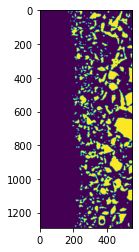

In [86]:
f.recon(0,9,5)

In [2]:


N = StructuralNetwork('TestData/AgNWN_Aligned/GT_Subset/100_020')
N.stack_to_gsd(crop=crop)
N.G_u()

from scipy.spatial.transform import Rotation as R
r = R.from_rotvec(45/180*np.pi * np.array([0, 0, 1]))
N.rotate = r.as_matrix()


centre = np.asarray(N.shape)/2
length = N.inner_crop[0]*0.5
outer_crop = np.array([centre[0]-length,
                       centre[0]+length,
                       centre[1]-length,
                       centre[1]+length], dtype=int)

node_positions = np.asarray(list(N.Gr.vs[i]['o'] for i in range(N.Gr.vcount())))
plt.scatter(node_positions.T[0], node_positions.T[1])
plt.show()
print(node_positions)
node_positions = base.oshift(node_positions, _shift=centre)
print(node_positions)
node_positions = np.vstack((node_positions.T, np.zeros(len(node_positions)))).T
print(node_positions)
node_positions = np.matmul(node_positions, N.rotate)#.T[0:2].T
print('after mm',node_positions)
node_positions = node_positions.T[0:2].T
print(node_positions)
node_positions = base.oshift(node_positions, _shift=-centre)
print(node_positions)

for i in range(self.Gr.vcount()):
    if not Q_inside(np.asarray([node_positions[i]]), outer_crop):
        drop_list.append(i)
        continue
                    
    self.Gr.vs[i]['o'] = node_positions[i]
    self.Gr.vs[i]['pts'] = node_positions[i]

self.Gr.delete_vertices(drop_list)

print(list(min(node_positions.T[i]) for i in (0,1)))

plt.scatter(node_positions.T[0], node_positions.T[1])
plt.show()

NameError: name 'crop' is not defined

In [145]:
import copy
Gr_copy = copy.deepcopy(f.Gr)

print(f.Gr.vcount())
f.Gr.delete_vertices(1)
print(f.Gr.vcount())

f.Gr = Gr_copy
print(f.Gr.vcount())


10629
10628
10629


pre sub has  1497  nodes
post sub has  178  nodes


IndexError: index 2 is out of bounds for axis 0 with size 0

<Figure size 720x1800 with 0 Axes>

In [129]:
node_positions = np.asarray(list(N.Gr.vs()[i]['o'] for i in range(N.Gr.vcount())))

print(list(max(node_positions.T[i]) for i in (0,1)))

[424.0, 424.0]


In [68]:
print(list(N.Gr.vs()))

[igraph.Vertex(<igraph.Graph object at 0x1457558b0>, 0, {'pts': array([299., 269.]), 'o': array([299., 269.])}), igraph.Vertex(<igraph.Graph object at 0x1457558b0>, 1, {'pts': array([300., 258.]), 'o': array([300., 258.])}), igraph.Vertex(<igraph.Graph object at 0x1457558b0>, 2, {'pts': array([300., 242.]), 'o': array([300., 242.])}), igraph.Vertex(<igraph.Graph object at 0x1457558b0>, 3, {'pts': array([300., 180.]), 'o': array([300., 180.])}), igraph.Vertex(<igraph.Graph object at 0x1457558b0>, 4, {'pts': array([300.,  80.]), 'o': array([300.,  80.])}), igraph.Vertex(<igraph.Graph object at 0x1457558b0>, 5, {'pts': array([300.,   3.]), 'o': array([300.,   3.])}), igraph.Vertex(<igraph.Graph object at 0x1457558b0>, 6, {'pts': array([300.,   1.]), 'o': array([300.,   1.])}), igraph.Vertex(<igraph.Graph object at 0x1457558b0>, 7, {'pts': array([299., 263.]), 'o': array([299., 263.])}), igraph.Vertex(<igraph.Graph object at 0x1457558b0>, 8, {'pts': array([299., 198.]), 'o': array([299., 1

In [23]:
#print(list(Gr_copy.es[i]['pts'] for i in range(Gr_copy.ecount())))
np.asarray(list(f.Gr.es[i]['pts'][2] for i in range(f.Gr.ecount())))

array([[   0,  282,  241],
       [   2,   13,  195],
       [   1,   16,  199],
       ...,
       [   4, 1167,  295],
       [   4, 1268,  252],
       [   4, 1289,  422]], dtype=int16)

In [70]:
scale=1
img_options={"Thresh_method":0, "gamma": 0.62, "md_filter": 0, "g_blur": 1, "autolvl": 0,
             "fg_color":0, "laplacian": 0, "scharr": 0, "sobel":0 , "lowpass": 0, "asize": int((11*scale))*2+1,
             "bsize":int((3*scale))*2+1, "wsize": int((10*scale))*2+1, "thresh": 137}

f = StructuralNetwork('TestData/CeO')
#f.binarize(options_dict=img_options)
f.stack_to_gsd(crop=[700,1250,10,1300,0,10], debubble=[ball(1)])
f.G_u()
f.node_calc(Betweenness=False, Closeness=False)
f.Node_labelling(f.Degree, 'Degree', 'test1.gsd')

Ran stack_to_gsd() in  3.4491310119628906 for gsd with  16890 particles
Ran debubble in  2.088930130004883 for an image with shape  (10, 1290, 550)
name is  TestData/CeO/Binarized/debubbled_skel.gsd
gsd_to_G canvas has shape  (10, 1290, 550)
[[  0   5 361]]
(0, 1186, array([[  0,   5, 361],
       [  0,   5, 360],
       [  0,   6, 359],
       [  0,   5, 358],
       [  0,   6, 357],
       [  0,   6, 356],
       [  0,   6, 355],
       [  0,   6, 354],
       [  1,   6, 353],
       [  1,   6, 352],
       [  2,   6, 351],
       [  3,   6, 350],
       [  4,   6, 350],
       [  5,   6, 350],
       [  6,   5, 349],
       [  7,   5, 349],
       [  8,   5, 349]], dtype=int16))
Ran gsd_to_G in  9.570481061935425 for a graph with  1497 nodes.


implicit data copy when writing chunk: log/particles/Degree


In [4]:
scale=1
img_options={"Thresh_method":0, "gamma": 0.62, "md_filter": 0, "g_blur": 1, "autolvl": 0,
             "fg_color":0, "laplacian": 0, "scharr": 0, "sobel":0 , "lowpass": 0, "asize": int((11*scale))*2+1,
             "bsize":int((3*scale))*2+1, "wsize": int((10*scale))*2+1, "thresh": 137}

f = StructuralNetwork('TestData/CeO')
#f.binarize(options_dict=img_options)
f.stack_to_gsd(crop=[700,1250,10,1300,0,30], debubble=[ball(1)])
f.G_u()
f.node_calc(Betweenness=False, Closeness=False)
f.Node_labelling(f.Degree, 'Degree', 'test1.gsd')

/Users/alaink/miniconda3/envs/v3_env/lib/python3.9/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


Ran stack_to_gsd() in  10.79012393951416 for gsd with  50183 particles
Ran debubble in  6.579121112823486 for an image with shape  (30, 1290, 550)
name is  TestData/CeO/Binarized/debubbled_skel.gsd
gsd_to_G canvas has shape  (30, 1290, 550)
[[  0   5 361]]
(0, 1072, array([[  0,   5, 361],
       [  0,   5, 360],
       [  0,   6, 359],
       [  0,   5, 358],
       [  0,   6, 357],
       [  0,   6, 356],
       [  0,   6, 355],
       [  0,   6, 354],
       [  1,   6, 353],
       [  1,   6, 352],
       [  2,   6, 351],
       [  3,   6, 350],
       [  4,   6, 350],
       [  5,   6, 350],
       [  6,   5, 349],
       [  7,   5, 349],
       [  8,   5, 349]], dtype=int16))
Ran gsd_to_G in  27.713982105255127 for a graph with  3577 nodes.


implicit data copy when writing chunk: log/particles/Degree


In [48]:
f = ResistiveNetwork('TestData/AgNWN_Aligned/GT_Subset/100_020')
f.stack_to_gsd(crop=[600,900,600,900], rotate=45, debubble=[disk(2)])
f.potential_distribution(0, [0,20], [480,500], R_j=0, rho_dim=0.69)
f.Node_labelling(f.P, 'P', 'test1.gsd')

assigned img attr in  0.0006389617919921875
Ran stack_to_gsd() in  0.06233692169189453 for gsd with  9822 particles
Ran debubble in  0.04645490646362305 for an image with shape  (1, 300, 300)
gsd_to_G canvas has shape  (300, 300)
[[ 0 27]
 [ 0 28]]
(1, 8, array([[  0,  96],
       [  0,  97],
       [  0,  98],
       [  0,  99],
       [  1, 100],
       [  1, 101],
       [  1, 102],
       [  1, 103],
       [  1, 104],
       [  2, 105]], dtype=int16))
Ran gsd_to_G in  0.41259288787841797 for a graph with  933 nodes.
pre sub has  775  nodes
post sub has  422  nodes
post sub has  422  nodes
Graph has max  [299, 299]
source coord is  [-10 149]
sink coord is  [309 149]
Before connecting external nodes, G has vcount  424
False  connected
After connecting external nodes, G has vcount  424
(424, 424) L


<ipython-input-46-712ba5ccde69>:336: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  edge_positions_list = np.asarray(list(base.oshift(self.Gr.es[i]['pts'], _shift=centre) for i in range(self.Gr.ecount())))
implicit data copy when writing chunk: log/particles/P


In [45]:
f = ResistiveNetwork('TestData/AgNWN_Aligned/GT_Subset/30_003')
f.stack_to_circular_gsd(500, debubble=[disk(2)])
f.potential_distribution(0, [0,20], [480,500], R_j=0, rho_dim=0.69)
o=f.effective_resistance()
print(o)

assigned img attr in  0.0007929801940917969
[  0 255]
Ran stack_to_gsd() in  0.5016841888427734 for gsd with  50776 particles
Ran debubble in  0.4710390567779541 for an image with shape  (1, 1018, 1536)
gsd_to_G canvas has shape  (999, 999)
[[  1 508]]
(0, 7, array([[  1, 508],
       [  1, 507],
       [  1, 506],
       [  1, 505],
       [  1, 504],
       [  1, 503],
       [  1, 502],
       [  1, 501],
       [  1, 500],
       [  2, 499],
       [  2, 498],
       [  3, 497],
       [  3, 496],
       [  3, 495],
       [  3, 494],
       [  4, 493],
       [  4, 492],
       [  4, 491],
       [  4, 490],
       [  5, 489],
       [  5, 488],
       [  5, 487],
       [  6, 486],
       [  6, 485],
       [  6, 484],
       [  6, 483],
       [  6, 482],
       [  7, 481],
       [  7, 480],
       [  7, 479],
       [  7, 478],
       [  8, 477],
       [  8, 476],
       [  8, 475],
       [  8, 474],
       [  9, 473],
       [  9, 472],
       [  9, 471],
       [  9, 470],

In [87]:
scale=1
img_options={"Thresh_method":1, "gamma": 2.34, "md_filter": 0, "g_blur": 1, "autolvl": 0,
             "fg_color":1, "laplacian": 0, "scharr": 1, "sobel":0 , "lowpass": 1, "asize": int((103*scale))*2+1,
             "bsize":int((43*scale))*2+1, "wsize": int((10*scale))*2+1, "thresh": 127}

N = ResistiveNetwork('TestData/AgNWN_Aligned/GT_Subset/100_020')
O_eff_df=[]
nodes_df = []
#f.binarize(options_dict=img_options)
#thetas = np.linspace(0,350,36)
thetas = (45,60,180)
for theta in thetas:
    N.stack_to_gsd(crop=[200,300,200,300], rotate=theta)
    #N.G_u(weight_type='Resistance', R_j=0)
    N.G_u()
    N.potential_distribution(0, [0,20], [380,400])
    #L = N.L
    #Q = np.linalg.pinv(L)
    #O_eff = Q[-1,-1]+Q[-2,-2]-2*Q[-1,-2]
    #O_eff_df.append(O_eff)
    #nodes_df.append(f.Gr.vcount())
    N.Node_labelling(N.P, 'P', 'test1.gsd')
    print(N.crop)
    
stop
df = pd.DataFrame(columns=['Theta','O_eff','Nodes'])
df['O_eff'] = O_eff_df
df['Theta'] = thetas
df['Nodes'] = nodes_df

plt.scatter(df['Theta'],df['O_eff'])
plt.show()

Ran stack_to_gsd() in  0.046386003494262695 for gsd with  2228 particles
name is  TestData/AgNWN_Aligned/GT_Subset/100_020/Binarized/skel.gsd
gsd_to_G canvas has shape  (141, 141)
[[ 0 30]]
(0, 7, array([[ 0, 30],
       [ 0, 29],
       [ 0, 28],
       [ 1, 27],
       [ 1, 26],
       [ 2, 25],
       [ 2, 24],
       [ 2, 23],
       [ 2, 22],
       [ 3, 21],
       [ 3, 20],
       [ 3, 19],
       [ 4, 18]], dtype=int16))
Ran gsd_to_G in  0.11487889289855957 for a graph with  288 nodes.
[140, 140]
name is  TestData/AgNWN_Aligned/GT_Subset/100_020/Binarized/skel.gsd
gsd_to_G canvas has shape  (141, 141)


<ipython-input-83-0b768461bb59>:349: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  edge_positions_list = np.asarray(list(base.oshift(self.Gr.es[i]['pts'], _shift=centre) for i in range(self.Gr.ecount())))
implicit data copy when writing chunk: log/particles/P


[[ 0 30]]
(0, 7, array([[ 0, 30],
       [ 0, 29],
       [ 0, 28],
       [ 1, 27],
       [ 1, 26],
       [ 2, 25],
       [ 2, 24],
       [ 2, 23],
       [ 2, 22],
       [ 3, 21],
       [ 3, 20],
       [ 3, 19],
       [ 4, 18]], dtype=int16))
Ran gsd_to_G in  0.1145470142364502 for a graph with  288 nodes.
[140, 140]
pre sub has  131  nodes
post sub has  25  nodes
post sub has  25  nodes
Graph has max  [98.99494936611666, 98.2878425849301]
source coord is  [-10  49]
sink coord is  [108  49]
Before connecting external nodes, G has vcount  27
False  connected
After connecting external nodes, G has vcount  27
(27, 27) L
[  0 141   0 141]
Ran stack_to_gsd() in  0.05564689636230469 for gsd with  2228 particles
name is  TestData/AgNWN_Aligned/GT_Subset/100_020/Binarized/skel.gsd
gsd_to_G canvas has shape  (141, 141)
[[ 0 30]]
(0, 7, array([[ 0, 30],
       [ 0, 29],
       [ 0, 28],
       [ 1, 27],
       [ 1, 26],
       [ 2, 25],
       [ 2, 24],
       [ 2, 23],
       [ 2, 22]

implicit data copy when writing chunk: log/particles/P


Ran gsd_to_G in  0.2342970371246338 for a graph with  288 nodes.
[140, 140]
pre sub has  134  nodes
post sub has  27  nodes
post sub has  27  nodes
Graph has max  [98.22947341949747, 98.7653718043597]
source coord is  [-10  49]
sink coord is  [108  49]
Before connecting external nodes, G has vcount  29
False  connected
After connecting external nodes, G has vcount  29
(29, 29) L
[  0 141   0 141]
Ran stack_to_gsd() in  0.09425902366638184 for gsd with  2228 particles
name is  TestData/AgNWN_Aligned/GT_Subset/100_020/Binarized/skel.gsd
gsd_to_G canvas has shape  (141, 141)
[[ 0 30]]
(0, 7, array([[ 0, 30],
       [ 0, 29],
       [ 0, 28],
       [ 1, 27],
       [ 1, 26],
       [ 2, 25],
       [ 2, 24],
       [ 2, 23],
       [ 2, 22],
       [ 3, 21],
       [ 3, 20],
       [ 3, 19],
       [ 4, 18]], dtype=int16))
Ran gsd_to_G in  0.24355816841125488 for a graph with  288 nodes.
[140, 140]
name is  TestData/AgNWN_Aligned/GT_Subset/100_020/Binarized/skel.gsd
gsd_to_G canvas has sh

implicit data copy when writing chunk: log/particles/P


[140, 140]
pre sub has  137  nodes
post sub has  22  nodes
post sub has  22  nodes
Graph has max  [100.0, 100.0]
source coord is  [-10  50]
sink coord is  [110  50]
Before connecting external nodes, G has vcount  24
False  connected
After connecting external nodes, G has vcount  24
(24, 24) L
[  0 141   0 141]


NameError: name 'stop' is not defined

In [193]:
N.rotate

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [15]:
np.asarray(f.crop) - min(f.crop)

array([  0, 400,   0, 400])

In [22]:
L = f.L
Q = f.Q
print(Q[-1,-1]+Q[-2,-2]-2*Q[-2,-1])

858.0686097649682


In [50]:
0.5*np.array([2,4])

array([1., 2.])

In [51]:
np.swapaxes(f.img_bin,0,0) == f.img_bin

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [158]:
f = ResistiveNetwork('TestData/AgNWN_10um')
f.binarize()
f.stack_to_gsd(crop=[300,600,10,500], debubble=[disk(3)])
f.G_u()
f.potential_distribution(1, [0,20], [480,500])
base.Node_labelling(f, f.P, 'P', 'test1.gsd')

3


IndexError: list index out of range

In [ ]:
"""Examples:
f = ResistiveNetwork('TestData/AgNWN_10um')
f.binarize()
f.stack_to_gsd(crop=[300,600,0,500], debubble=[disk(3)])
f.G_u()
f.potential_distribution(1, [0,20], [480,500])
base.Node_labelling(f, f.P, 'P', 'test1.gsd')

g = ResistiveNetwork('TestData/pores-hi-res-crop')
g.stack_to_gsd(crop=[0,100,0,100,0,100], debubble=[ball(3)])
g.G_u()
g.potential_distribution(0, [0,20], [80,100])
base.Node_labelling(g, g.P, 'P', 'test2.gsd')

scale=1
img_options={"Thresh_method":1, "gamma": 2.34, "md_filter": 0, "g_blur": 1, "autolvl": 0,
             "fg_color":1, "laplacian": 0, "scharr": 1, "sobel":0 , "lowpass": 1, "asize": int((103*scale))*2+1,
             "bsize":int((43*scale))*2+1, "wsize": int((10*scale))*2+1, "thresh": 127}
s = StructuralNetwork('TestData/fibres-hi-res-crop')
s.binarize(options_dict=img_options)
s.stack_to_gsd(crop=[0,100,0,100,0,100])
s.G_u()
s.node_calc()
base.Node_labelling(s, s.Degree, 'Degree', 'test3.gsd')
"""

f = ResistiveNetwork('TestData/AgNWN_10um')
f.stack_to_circular_gsd(400, rotate=45, debubble=[disk(1)])
f.G_u()
f.potential_distribution(1, [0,50], [750,800])
Node_labelling(f, f.P, 'P', 'test1.gsd')

In [ ]:
#Rotation test
#Continuous rotation analysis
#Testing base.py implementation
#This implementation rotates the image itself

#######################################################
## USE THIS CELL FOR TESTING THE ABOVE DECLARATIONS ##
## USE A SEPARATE NOTEBOOK FOR TESTING network.py   ##
#######################################################

from PIL import Image
from skimage.morphology import binary_closing, disk, ball, skeletonize_3d
import network
g = network.ResistiveNetwork('TestData/AgNWN_10um')
g.binarize()

#thetas = np.linspace(0.001,350, 4)
thetas = (0,45)

#crop = 359

#Need to reassign weights from a temporary rotated binary image
#First write the temporary image
#Must calculate positions for the crop because this crop is origin cornered (and not origin centred, like the one above)
img_bin = cv.imread(g.stack_dir+'/slice0.tiff') #Original image
image_center = tuple(np.array(img_bin.shape[1::-1]) / 2)
short_length = img_bin.shape[img_bin.shape == max(img_bin.shape)]
long_length = max(img_bin.shape)
ISS = (short_length**2/2)**0.5
L1 = int((long_length - ISS)/2)
L3 = int(ISS+L1)
L2 = int((short_length - ISS)/2)
L4 = int(ISS+L2)
o_corn_crop = [L2,L1,L4,L3]
dims = L2-L1



R_j = 0
O_eff_df = []
Ax_df = []
Ay_df = []
theta_df = []
nodes = []
for theta in thetas:
    g.stack_to_gsd(name='Rotations/ObjectImplementation/rot_skel.gsd', crop=[L1,L3,L2,L4], rotate=theta, debubble=[disk(2)])
    g.G_u()
    measuring_graph = base.add_weights(g, weight_type='Resistance', R_j=R_j)
    g.potential_distribution(0, [0,20], [727-20,727], R_j=R_j, rho_dim=0.89)
    base.Node_labelling(g, g.P, 'P', 'take2.gsd')
    print(g.Gr_connected.vcount())
    print(measuring_graph.vcount())
    
    #Ax, Ay = base.gyration_moments(g.Gr, sampling = 0.1)
    #L = g.L
    #Q = np.linalg.pinv(L)
    #O_eff = Q[-1,-1]+Q[-2,-2]-2*Q[-1,-2]
    
    nodes.append(g.Gr.vcount())
    df_cont = pd.DataFrame(columns=['Theta','O_eff','Ax','Ay'])
    df_cont['O_eff'] = O_eff_df
    df_cont['Ax'] = Ax_df
    df_cont['Ay'] = Ay_df
    df_cont['Theta'] = theta_df
    #df_cont.to_csv('AgNWN.csv')

    df_cont
    #print(theta, O_eff, Ax, Ay)
    
    #stop
    
    
    #O_eff_df.append(O_eff)
    #Ax_df.append(Ax)
    #Ay_df.append(Ay)
    #theta_df.append(theta)



In [ ]:
len(np.asarray(np.where(np.asarray(g.img_bin_3d)!=0)).T)

In [5]:
f.shape

[994, 992]

In [176]:
!conda env list

# conda environments:
#
base                     /Users/alaink/miniconda3
MLProject                /Users/alaink/miniconda3/envs/MLProject
SGT                      /Users/alaink/miniconda3/envs/SGT
igraph                   /Users/alaink/miniconda3/envs/igraph
ovito                    /Users/alaink/miniconda3/envs/ovito
signac-dev               /Users/alaink/miniconda3/envs/signac-dev
v2_env                   /Users/alaink/miniconda3/envs/v2_env
v3_env                *  /Users/alaink/miniconda3/envs/v3_env



In [ ]:
g.img_bin_3d
img_bin = np.swapaxes(g.img_bin_3d, 0, 2)

crop = o_corn_crop
img_bin[crop[2]:crop[3], crop[0]:crop[1]].shape

TypeError: draw_graph() missing 1 required positional argument: 'graph'

In [ ]:

img_bin=[]
img_bin.append(img_slice)
img_bin = np.asarray(img_bin)
img_bin = np.swapaxes(img_bin, 0, 2)
print(img_bin.shape)
img_bin = img_bin[crop[2]:crop[3],crop[0]:crop[1]]
print(img_bin.shape)

In [ ]:
def timer(_class,method):
    """Print the runtime of the decorated function"""
    @functools.wraps(method)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()    # 1
        value = _method(*args, **kwargs)
        end_time = time.perf_counter()      # 2
        run_time = end_time - start_time    # 3
        print(f"Finished {method.__name__!r} in {run_time:.4f} secs")
        print(_class)
        print(method)
        return value
    return wrapper_timer